In [ ]:
import random
from collections import OrderedDict
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import pubchempy as pcp

from config import project_path
from my_nets.Create_dataset import SS_Dataset
from my_nets.LinearNet import LinearNet3
from my_nets.net_func import load_ckp
from my_nets.net_func import get_trained_model
from Vectorizers.vectorizers import get_dictionary, get_sample, get_sdf_file
# from Vectorizers.vectorizers import *

from sklearn.metrics import mean_squared_error as MSE
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import clone

from rdkit import RDLogger, Chem
from rdkit.Chem import AllChem

from chemreps.bagger import BagMaker
from chemreps.just_bonds import bonds

class my_datasets:
    def __init__(self):
        self.ds = []
        self.X = np.array([])
        self.y = np.array([])

torch.random.manual_seed(212)
random.seed(212)
np.random.seed(212)

create_manually = False

# Create datasets of MNSol

In [ ]:
MnSol_datasets = {}
norms = {}

## JB - JB dataset

In [ ]:
solvent_vectorizer = 'JB'
solute_vectorizer = 'JB'
norm_bools = (True, True, True)

In [ ]:
table_v1 = pd.read_table(project_path('Tables/SS_table_v3.tsv'))
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = dataset.train_val_split(0.9)

solvent_table = pd.read_table(project_path('Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

MnSol_datasets['JB_JB'] = {
    'train':train_dataset,
    'val': val_dataset,
    'solvent': solvent_test_dataset,
    'solute': solute_test_dataset}

In [ ]:
# saving norms for later
norms['JB_JB'] = MnSol_datasets['JB_JB']['solvent'].norm_params

# Permutation Importance

## KRR JB JB

In [ ]:
KRR_JB_JB = get_trained_model('KRR', 'JB', 'JB', 'laplacian')

### With fit

In [ ]:
control = {}
for name in ('train', 'val', 'solvent', 'solute'):
    y_true = MnSol_datasets['JB_JB'][name].y
    y_pred = KRR_JB_JB.predict(MnSol_datasets['JB_JB'][name].X)
    control[name] = MSE(y_true, y_pred)

In [ ]:
length = len(MnSol_datasets['JB_JB']['train'].X[0])
scores = {'fit':[], 'feat_zero': [], 'feat_rand': []}
important_features = {'fit':[], 'feat_zero': [], 'feat_rand': []}
fi_scores = {'fit': {}, 'feat_zero': {}, 'feat_rand': {}}
KRR_fi = []
for i in tqdm(range(length)):
    mask = np.array([1,] * length)
    mask[i] = 0
    X = [np.array(x)*mask for x in MnSol_datasets['JB_JB']['train'].X]
    y = MnSol_datasets['JB_JB']['train'].y
    KRR_i = clone(KRR_JB_JB)
    KRR_fi.append(KRR_i)
    KRR_fi[i].fit(X, y)
    sc = {}

    for name in MnSol_datasets['JB_JB']:
        X = [x*mask for x in MnSol_datasets['JB_JB'][name].X]
        y_true = MnSol_datasets['JB_JB'][name].y
        y_pred = KRR_fi[i].predict(X)
        sc[name] = MSE(y_true, y_pred)

    scores['fit'].append(sc)

for name in ('train', 'val', 'solvent', 'solute'):
    fi_scores['fit'][name] = [scores['fit'][i][name]-control[name] for i in range(length)]

In [ ]:
plt.figure(figsize=(15,5))
for name in ('train', 'val', 'solvent', 'solute'):
    plt.plot(fi_scores['fit'][name])
plt.legend(('train', 'val', 'solvent', 'solute'))
plt.show()


### Without Fit Zeros

In [ ]:
length = len(MnSol_datasets['JB_JB']['train'].X[0])
for i in  tqdm(range(length)):
    mask = np.array([1,] * length)
    mask[i] = 0
    sc = {}
 
    for name in MnSol_datasets['JB_JB']:
        X = [np.array(x)*mask for x in MnSol_datasets['JB_JB'][name].X]
        y_true = MnSol_datasets['JB_JB'][name].y
        y_pred = KRR_JB_JB.predict(X)
        sc[name] = MSE(y_true, y_pred)

    scores['feat_zero'].append(sc)

In [ ]:
for name in ('train', 'val', 'solvent', 'solute'):
    fi_scores['feat_zero'][name] = [scores['feat_zero'][i][name]-control[name] for i in range(length)]

plt.figure(figsize=(15, 5))
for name in ('train', 'val', 'solvent', 'solute'):
    plt.plot(fi_scores['feat_zero'][name])
plt.legend(('train', 'val', 'solvent', 'solute'))
plt.show()


### Without Fit Random

In [ ]:
length = len(MnSol_datasets['JB_JB']['train'].X[0])
for i in tqdm(range(length)):
    mask = np.array([1,] * length)
    mask[i] = np.random.normal(loc=0, scale=1,size=None)
    sc = {}

    for name in MnSol_datasets['JB_JB']:
        X = [np.array(x)*mask for x in MnSol_datasets['JB_JB'][name].X]
        y_true = MnSol_datasets['JB_JB'][name].y
        y_pred = KRR_JB_JB.predict(X)
        sc[name] = MSE(y_true, y_pred)

    scores['feat_rand'].append(sc)



In [ ]:
for name in ('train', 'val', 'solvent', 'solute'):
    fi_scores['feat_rand'][name] = [scores['feat_rand'][i][name]-control[name] for i in range(length)]

plt.figure(figsize=(15, 5))
for name in ('train', 'val', 'solvent', 'solute'):
    plt.plot(fi_scores['feat_rand'][name])
plt.legend(('train', 'val', 'solvent', 'solute'))
plt.show()

In [ ]:
# with open(project_path('Tables/Feat_importance_scores.pkl'), 'wb') as f:
#     pkl.dump(fi_scores, f)

In [ ]:
# dataset = project_path('Tables/Reserve/Sdf')
# bagger = BagMaker('JustBonds', dataset)
#
# # Create dictionary of i to bags for later
# JB_bag_i = {}
# tracker = 0
#
# for bag, size in bagger.bag_sizes.items():
#     for j in range(size+1):
#         JB_bag_i[tracker] = (bag, j)
#         tracker+=1

In [ ]:
# n_feat = 20
# for method in fi_scores:
#     for v in (-np.array(fi_scores[method]['solute'])).argsort()[:n_feat]:
#         if v < 282:
#             compound = 'S: Solvent'
#             b = JB_bag_i[v]
#         else:
#             compound = 'U: Solute'
#             b = JB_bag_i[v-282]
#         important_features[method].append((compound, b[0], b[1], fi_scores[method]['solute'][v]))

In [ ]:
# FI_pd = pd.DataFrame({name:[v[:3] for v in values] for name, values in important_features.items()})
# FI_pd

## KRR Class Morgan

## Permutation Importance

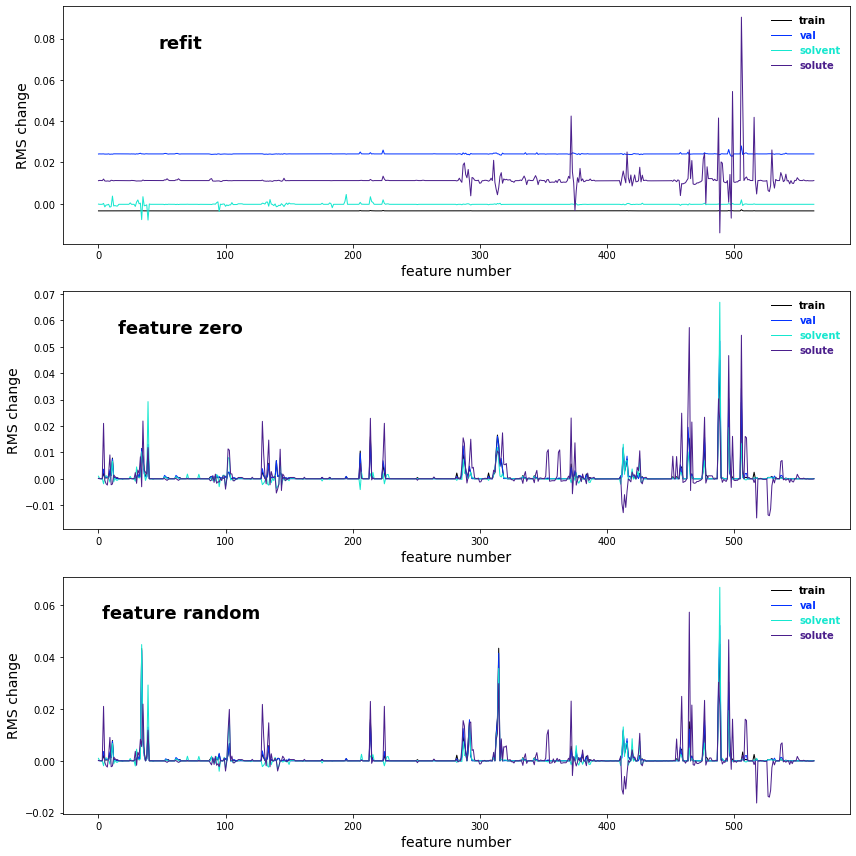

In [16]:
sp = (311, 312, 313, 235, 233, 236)
plt.subplots(3,1, figsize=(12, 12))
plt.style='scientific'
labels = ['refit', 'feature zero', 'feature random']
methods = ['fit', 'feat_zero', 'feat_rand']
colors = {'train':'black', 'val':'#0433FF', 'solvent':'#16E7CF', 'solute':'#4B1F8C'}
for i in range(3):
    plt.subplot(sp[i])
    plt.xlabel('feature number', fontsize=14)
    plt.ylabel('RMS change', fontsize=14)
    plt.title(labels[i], x=0.15, y=0.8, fontweight = 'bold', fontsize=18)


    for name in ('train', 'val', 'solvent', 'solute'):
        plt.plot(fi_scores[methods[i]][name], color=colors[name], linewidth=1)
        plt.legend(('train', 'val', 'solvent', 'solute'), frameon=False, labelcolor='linecolor', fontsize=14, loc='upper right',prop=dict(weight='bold'))

plt.tight_layout()
plt.savefig(project_path('Examples/results/9_Feature_imp.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create bag mask
n_feat = 20
twenty_feat = sorted(list((-np.array(fi_scores['feat_zero']['solute'])).argsort()[:n_feat]))

cb = {'S':[], 'U':[]}
for f in twenty_feat:
    if f < 282:
        d = 'S'
        fff = f
    else:
        d = 'U'
        fff = f-282
    cb[d].append(JB_bag_i[fff][0])

cb2 = {}
for k, v in cb.items():
    cb2[k] = set(v)

color_bags = {'C':'#333333', 'CC':'#929292', 'HC':'#945200', 'H':'#941100', 'N':'#FF2F92', 'NC':'#5A1B37', 'NH':'#FFB0CD', 'O':'#0433FF', 'OC':'#2A124B', 'OH':'#00FDFF', 'ON':'#9437FF'}

bags_borders = {}
tracker = 0
for bag, size in bagger.bag_sizes.items():
    bags_borders[bag]=(tracker, tracker+size+1)
    tracker += size+1

bins = [v[0] for k, v in bags_borders.items()]+ [v[0]+282 for k, v in bags_borders.items()] + [563,]

plt.figure(figsize=(12, 1))
N, bin, patches = plt.hist(bins[:-1], bins=bins)
# print(len(patches))
for i in range(len(patches)):
    if i<34:
        bag = list(bagger.bags.keys())[i]
        d='S'
    else:
        bag = list(bagger.bags.keys())[i-34]
        d='U'
    # print(bag, i)
    if bag in cb2[d]:
        patches[i].set_facecolor(color_bags[bag])
        patches[i].set_alpha(0.5)
    else:
        patches[i].set_facecolor('white')
        patches[i].set_alpha(0)

plt.axis('off')
plt.savefig(project_path('Examples/results/Feature_imp_bags.png'))